### Крутой гайд https://pytorch.org/tutorials/beginner/chatbot_tutorial.html?highlight=tokenizer
### FastText medium 2.9 claps https://towardsdatascience.com/word-embedding-with-word2vec-and-fasttext-a209c1d3e12c
#### https://arxiv.org/pdf/1711.01068.pdf
#### https://www.aclweb.org/anthology/P16-2063
#### https://aclweb.org/anthology/D17-1309
#### https://medium.com/@b.terryjack/nlp-everything-about-word-embeddings-9ea21f51ccfe
#### https://towardsdatascience.com/nlp-learning-series-part-3-attention-cnn-and-what-not-for-text-classification-4313930ed566
#### https://medium.com/jatana/report-on-text-classification-using-cnn-rnn-han-f0e887214d5f
#### https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.utils.data as data

# import fasttext
from gensim.models.fasttext import FastText

from utils import clean_text, EmbeddingFastText, CommentsDataset
from classifiers import RNNClassifier
from train import train

%load_ext autoreload
%autoreload 2

In [2]:
random_state = 42

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# Data Loading

In [4]:
DATA_ROOT = 'data/train.csv'
df = pd.read_csv(DATA_ROOT)

In [5]:
print('size of datafra2me:', df.shape)
df.head(10)

size of datafra2me: (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [176]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [6]:
LABELS = list(df.columns[2:])

# Data Analysis

### 1. General information

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


#### No null positions

In [8]:
for l in LABELS:
    print(df[l].value_counts(normalize=True))

0    0.904156
1    0.095844
Name: toxic, dtype: float64
0    0.990004
1    0.009996
Name: severe_toxic, dtype: float64
0    0.947052
1    0.052948
Name: obscene, dtype: float64
0    0.997004
1    0.002996
Name: threat, dtype: float64
0    0.950636
1    0.049364
Name: insult, dtype: float64
0    0.991195
1    0.008805
Name: identity_hate, dtype: float64


In [9]:
df.describe(include=['int64'])

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Number of zeros is much bigger than ones


In [10]:
if len(np.unique(df['id'])) == df.shape[0]:
    print("All commentators are unique")

All commentators are unique


### 2. Let's see the text information

In [11]:
df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [12]:
df['comment_text'][0].lower()

"explanation\nwhy the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.89.205.38.27"

In [13]:
lenghts = [len(com) for com in df['comment_text']]
print(np.median(lenghts))
print(np.mean(lenghts))
print(np.max(lenghts))
print(np.min(lenghts))

205.0
394.0732213246768
5000
6


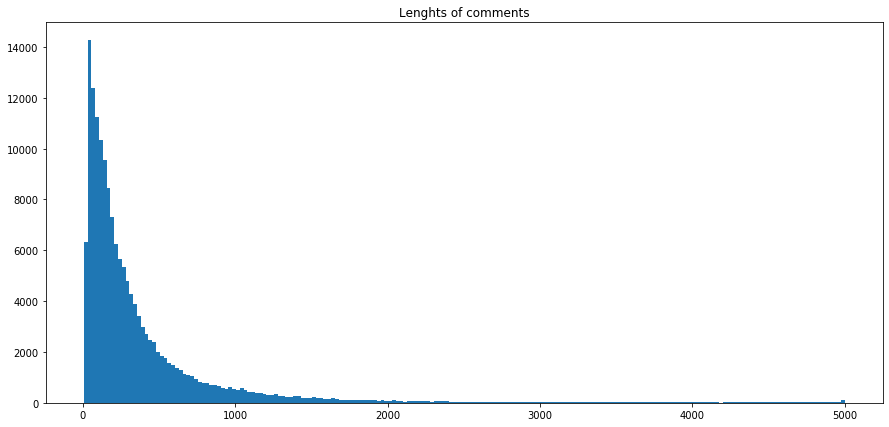

In [14]:
plt.figure(figsize=(15, 7))
plt.hist(lenghts, bins=200)  # arguments are passed to np.histogram
plt.title("Lenghts of comments")
plt.show()

In [15]:
pd.DataFrame(lenghts).describe()

,0
count,159571.000000
mean,394.073221
std,590.720282
min,6.000000
25%,96.000000
50%,205.000000
75%,435.000000
max,5000.000000


#### Can see from histogram and table that most of comments have lenghts less than 500 symbols, which is actually really natural fact

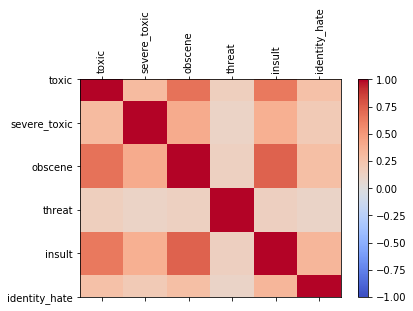

In [16]:
data = df[LABELS]
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

#### Toxic, obscene and insult are more often together, as real comments in twitter:))), don't know is this information useful for solution

### Очистка данных https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

# Building baseline

#### Clean texts from sybbols like \n and other thrash and split it into separate words

In [17]:
# основа https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
# REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_)(:!?*%]')

# df['comment_text'] = df['Consumer complaint narrative'].apply(clean_text)
# df['comment_text'] = df['Consumer complaint narrative'].str.replace('\d+', '')

In [18]:
df['comment_text'] = df['comment_text'].apply(clean_text)

#### Split train-val

In [53]:
X, y = list(df['comment_text']), np.array(df[LABELS])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state)

#### Embedding

In [20]:
embedder = EmbeddingFastText(dim=100, window=5, min_count=5)  # size: dimentionality, min_count: min frequency of words

In [21]:
embedder.train(X_train)

#### Padding

Doing the same as in Data Analisys part, but for number of words

In [22]:
lenghts = [len(com) for com in X_train]
print(np.median(lenghts))
print(np.mean(lenghts))
print(np.max(lenghts))
print(np.min(lenghts))

35.0
65.77904681331077
1400
1


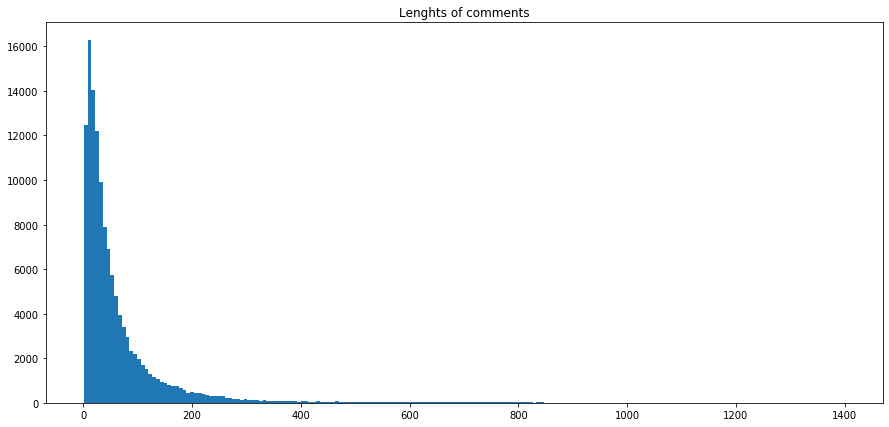

In [23]:
plt.figure(figsize=(15, 7))
plt.hist(lenghts, bins=200)  # arguments are passed to np.histogram
plt.title("Lenghts of comments")
plt.show()

The most of lenghts are less than 100, let's use this size for padding and cutting long sentences

In [24]:
LEN_SEN = 102

In [54]:
lengths_train = [len(sent) if len(sent)<LEN_SEN else LEN_SEN for sent in X_train]
lengths_val = [len(sent) if len(sent)<LEN_SEN else LEN_SEN for sent in X_val]

In [58]:
X_train = [torch.tensor(embedder(sent)) if len(sent) <=LEN_SEN 
           else torch.tensor(embedder(sent)[0:LEN_SEN]) for sent in X_train]
X_val = [torch.tensor(embedder(sent)) if len(sent) <=LEN_SEN 
           else torch.tensor(embedder(sent)[0:LEN_SEN]) for sent in X_val]

In [46]:
X_train[0].shape

torch.Size([102, 100])

In [27]:
X_train[0][0].shape

torch.Size([100])

In [59]:
X_train = pad_sequence(X_train, padding_value=0, batch_first=True)

In [60]:
X_train.shape

torch.Size([127656, 102, 100])

#### Simple RNN Model

In [164]:
from classifiers import RNNClassifier
model = RNNClassifier(input_size=100, num_layers=2)

In [62]:
# lengths_train = torch.tensor(lengths_train).view(-1, 1)
# lengths_val = torch.tensor(lengths_val).view(-1, 1)

In [63]:
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)

In [165]:
train(X_train, y_train, lengths_train, X_val, y_val, lengths_val, model, device)

  0%|          | 0/127656 [00:00<?, ?it/s]

Starting epoch 1...


127744it [02:24, 908.83it/s, NLL=0.916, epoch=1]                            
  0%|          | 0/127656 [00:00<?, ?it/s]

Starting epoch 2...


127744it [02:23, 964.43it/s, NLL=1.8, epoch=2]                              
  0%|          | 0/127656 [00:00<?, ?it/s]

Starting epoch 3...


127744it [02:24, 904.66it/s, NLL=1.06, epoch=3]                             
  0%|          | 0/127656 [00:00<?, ?it/s]

Starting epoch 4...


 50%|████▉     | 63744/127656 [01:07<01:09, 914.30it/s, NLL=0.917, epoch=4]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f36b6c6c048>
Traceback (most recent call last):
  File "/nmnt/media/home/farshov/miniconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/nmnt/media/home/farshov/miniconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/nmnt/media/home/farshov/miniconda3/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/nmnt/media/home/farshov/miniconda3/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/nmnt/media/home/farshov/miniconda3/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 



KeyboardInterrupt: 

In [174]:
with torch.no_grad():
    print(model.to('cpu')(pad_sequence(X_train[0:25], 
                     padding_value=0, batch_first=True),
                    torch.tensor(lengths_train[0:25])))

tensor([[-2.3710, -5.6276, -2.7989, -5.5785, -2.8023, -5.4728],
        [-2.3710, -5.6276, -2.7989, -5.5785, -2.8023, -5.4728],
        [-2.3710, -5.6276, -2.7989, -5.5785, -2.8023, -5.4728],
        [-2.3710, -5.6276, -2.7989, -5.5785, -2.8023, -5.4728],
        [-2.3710, -5.6276, -2.7989, -5.5785, -2.8023, -5.4728],
        [-2.3710, -5.6276, -2.7989, -5.5785, -2.8023, -5.4728],
        [-2.3710, -5.6276, -2.7989, -5.5785, -2.8023, -5.4728],
        [-2.3710, -5.6276, -2.7989, -5.5785, -2.8023, -5.4728],
        [-2.3710, -5.6276, -2.7989, -5.5785, -2.8023, -5.4728],
        [-2.3710, -5.6276, -2.7989, -5.5785, -2.8023, -5.4728],
        [-2.3710, -5.6276, -2.7989, -5.5785, -2.8023, -5.4728],
        [-2.3710, -5.6276, -2.7989, -5.5785, -2.8023, -5.4728],
        [-2.3710, -5.6276, -2.7989, -5.5785, -2.8023, -5.4728],
        [-2.3710, -5.6276, -2.7989, -5.5785, -2.8023, -5.4728],
        [-2.3710, -5.6276, -2.7989, -5.5785, -2.8023, -5.4728],
        [-2.3710, -5.6276, -2.7989, -5.5

In [172]:
y_train[0:25]

tensor([[1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0]])

In [5]:
def is_interactive():
   return 'SHLVL' not in os.environ
import os

In [6]:
is_interactive()

False